### 1. Init

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import os

### 2. Data Reading

In [2]:
train_data = pd.read_csv("train.csv").iloc[:, 1:].dropna(how = 'any')
train_data.index = range(len(train_data))
test_data = pd.read_csv("test.csv").iloc[:, 1:]
submission = pd.read_csv("sample_submission.csv")

In [3]:
train_data.shape, test_data.shape

((39992, 2), (5000, 1))

In [4]:
train_data['data'] = train_data['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

C:\Users\AILab\AppData\Local\Temp\ipykernel_20912\803922289.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['data'] = train_data['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [5]:
train_data['data'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

category    0
data        0
dtype: int64


In [6]:
train_data.loc[train_data.data.isnull()][:5]

,category,data


In [7]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

39992


In [8]:
# test_data.drop_duplicates(subset = ['data'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['data'] = test_data['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글 이외 삭제
# test_data['data'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
# test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data['data']))

전처리 후 테스트용 샘플의 개수 : 5000


C:\Users\AILab\AppData\Local\Temp\ipykernel_20912\32633488.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['data'] = test_data['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글 이외 삭제


### 3. Mecab Tokeize

In [9]:
from konlpy.tag import Mecab
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

In [10]:
stop_words = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을']

### 4. Extract Nouns

In [11]:
X_train = []

text = list(train_data['data'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.nouns(text[i]) # 토큰화
  temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
  temp_X = [word for word in temp_X if len(word) > 1]
  X_train.append(temp_X)

100%|██████████| 39992/39992 [00:39<00:00, 1009.30it/s]


In [12]:
X_test = []

text = list(test_data['data'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.nouns(text[i]) # 토큰화
  temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
  # temp_X = [word for word in temp_X if len(word) > 1]
  X_test.append(temp_X)

100%|██████████| 5000/5000 [00:04<00:00, 1020.49it/s]


In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import *
import tensorflow.keras.backend as K
from datetime import datetime
from sklearn.model_selection import train_test_split

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [15]:
threshold = 11
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45833
등장 빈도가 10번 이하인 희귀 단어의 수: 33115
단어 집합에서 희귀 단어의 비율: 72.25143455588768
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.134287559411337


In [16]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 12719


In [17]:
tokenizer = Tokenizer(num_words = vocab_size) # num_words = vocab_size
tokenizer.fit_on_texts(X_train)
token_X_train = tokenizer.texts_to_sequences(X_train)
token_X_test = tokenizer.texts_to_sequences(X_test)

In [18]:
y_train = to_categorical(np.array(train_data['category']))

In [19]:
drop_train = [index for index, sentence in enumerate(token_X_train) if len(sentence) < 1]

In [20]:
# 빈 샘플들을 제거
del_X_train = np.delete(token_X_train, drop_train, axis=0)
del_y_train = np.delete(y_train, drop_train, axis=0)
print(len(del_X_train))
print(len(del_y_train))

39967
39967


c:\Users\AILab\anaconda3\envs\nlp\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


train data의 최대 길이 : 5837
train data의 평균 길이 : 70.93104311056622


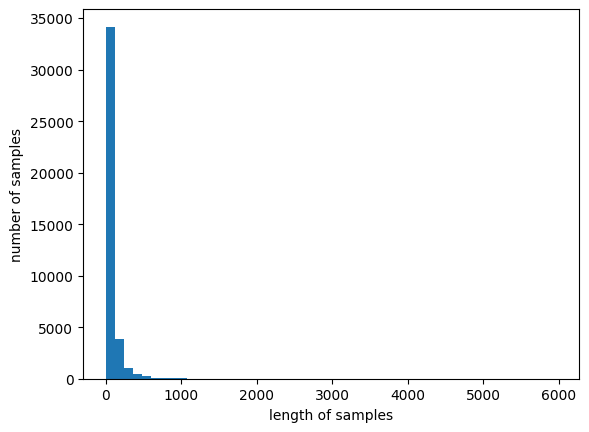

In [21]:
print('train data의 최대 길이 :',max(len(l) for l in del_X_train))
print('train data의 평균 길이 :',sum(map(len, del_X_train))/len(del_X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

test data의 최대 길이 :  3951
test data의 평균 길이 :  70.4604


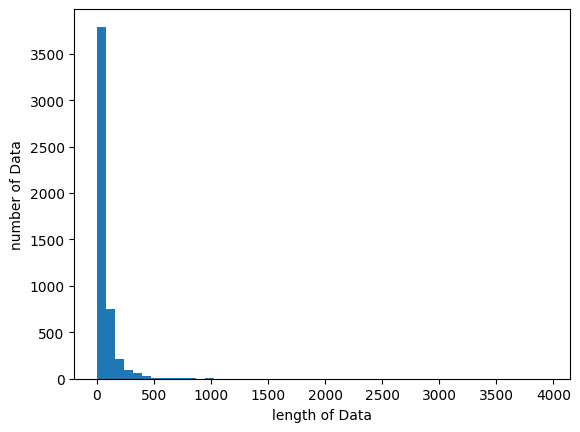

In [22]:
print("test data의 최대 길이 : ", max(len(l) for l in token_X_test))
print("test data의 평균 길이 : ", sum(map(len, token_X_test))/ len(token_X_test))
plt.hist([len(s) for s in token_X_test], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [23]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [24]:
max_len = 300
below_threshold_len(max_len, del_X_train)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 96.90244451672629


In [25]:
pad_X_train = pad_sequences(del_X_train, maxlen = max_len)
pad_X_test = pad_sequences(token_X_test, maxlen = max_len)

In [26]:
# pad_x_train, del_y_train // pad_X_test

In [27]:
pad_X_train[pad_X_train>2048]

array([3115, 4190, 3115, ..., 5984, 3034, 2951])

### 5. Modeling

In [28]:
path = './model'

In [29]:
class MultiHeadAttention(Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = Dense(embedding_dim)
        self.key_dense = Dense(embedding_dim)
        self.value_dense = Dense(embedding_dim)
        self.dense = Dense(embedding_dim)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embedding_dim' : self.embedding_dim,
            'num_heads' : self.num_heads,
            
            'projection_dim' : self.projection_dim,
            'query_dense' : self.query_dense,
            'key_dense' : self.key_dense,
            'value_dense' : self.value_dense,
            'dense' : self.dense
        })

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [30]:
class TransformerBlock(Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = Sequential(
            [Dense(dff, activation="relu"),
             Dense(embedding_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'att' : self.att,
            'ffn' : self.ffn,
            'layernorm1' : self.layernorm1,
            'layernorm2' : self.layernorm2,
            'dropout1' : self.dropout1,
            'dropout2' : self.dropout2
        })

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [31]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(vocab_size, embedding_dim)
        self.pos_emb = Embedding(max_len, embedding_dim)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'token_emb' : self.token_emb,
            'pos_emb' : self.pos_emb,
        })
        return config

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [32]:
embedding_dim = 32  # Embedding size for each token
num_heads = 4  # Number of attention heads
dff = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(8, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(3, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

In [33]:
ckpt_1 = 'tf_chkpoint.ckpt'
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
mc = ModelCheckpoint(filepath =  os.path.join(path, ckpt_1), monitor = 'val_accuracy', save_best_only = True, mode = 'max',verbose = 1, save_weights_only=True)
history = model.fit(pad_X_train, del_y_train, batch_size=32, epochs=4, validation_split=0.2, callbacks = [mc])

Epoch 1/4
The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
1000/1000 [==============================] - ETA: 0s - loss: 0.5181 - accuracy: 0.7765
Epoch 1: val_accuracy improved from -inf to 0.87741, saving model to ./model\tf_chkpoint.ckpt
1000/1000 [==============================] - 341s 325ms/step - loss: 0.5181 - accuracy: 0.7765 - val_loss: 0.3252 - val_accuracy: 0.8774
Epoch 2/4
 999/1000 [============================>.] - ETA: 0s - loss: 0.3100 - accuracy: 0.8869
Epoch 2: val_accuracy did not improve from 0.87741
1000/1000 [==============================] - 326s 326ms/step - loss: 0.3100 - accuracy: 0.8869 - val_loss: 0.3185 - val_accuracy: 0.8763
Epoch 3/4
 999/1000 [============================>.] - ETA: 0s - loss: 0.2564 - accuracy: 0.9063
Epoch 3: val_accuracy did not improve from 0.87741
1000/1000 [==============================] - 347s 348ms/step - loss: 0.2564 - accuracy: 0.9063 - val_lo

In [34]:
time_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(f'{time_str}: Done training.')

2022-10-26 14:55:17: Done training.


In [35]:
model.load_weights(os.path.join(path, ckpt_1))

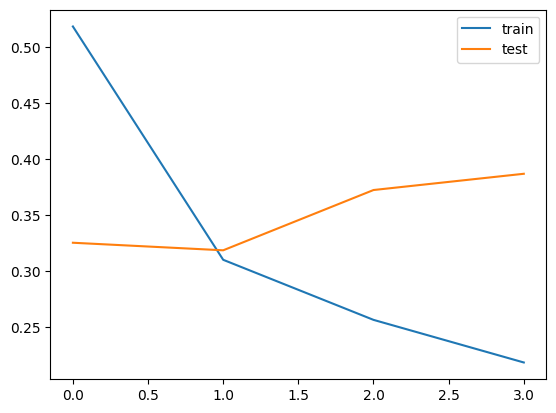

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [37]:
dot_img_file = './data_out/model_TF.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [38]:
y_pred = model.predict(pad_X_test)
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['category'] = np.argmax(y_pred, axis=-1)
sample_submission.head()

157/157 [==============================] - 21s 130ms/step


,index,category
0,0,0
1,1,2
2,2,1
3,3,1
4,4,2


In [39]:
sample_submission.to_csv('TF_submission_'+ datetime.now().strftime('%Y-%m-%d %H_%M_%S') + '.csv', encoding='utf-8', index=False)